# Walk Score

In this notebook I explore the idea of how well the city of Toronto does if your goal is walking to child care centers. There are three datasets used in this notebook, all of which come from the City of Toronto's website.

1) City of Toronto Addresses (https://open.toronto.ca/dataset/address-points-municipal-toronto-one-address-repository/). This serves as a sensible point of departure/destination when going to or from a child care center. Residents will find this useful as they can input their own address if traveling to or from their home. It's also useful for visitors or for people traveling to or from somewhere that isn't their home, as the nearest address can be used as a close approximation for their current loction.

2) The Toronto pedestrian network. (https://open.toronto.ca/dataset/pedestrian-network/) This serves as the valid pathways a traveler can take when moving from a child care center to an address or vice versa. 

3) City of Toronto Child Care Centers. (https://open.toronto.ca/dataset/licensed-child-care-centres/). These are the child care centers that serve as destinations/points of departure. 

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandana as pdna
import networkx as nx
from shapely.geometry import LineString
from PIL import Image

### Inspecting the Child Care Centers dataset

In [2]:
# Reading in a csv of one of our datasets just to take a look
df = pd.read_csv('raw_data/Child care centres - 4326.csv')

In [3]:
df.head()

_id  LOC_ID                                           LOC_NAME  \
0    1    1013              Lakeshore Community Child Care Centre   
1    2    1014            Alternative Primary School Parent Group   
2    3    1015     Cardinal Leger Child Care Centre (Scarborough)   
3    4    1016  George Brown - Richmond Adelaide Childcare Centre   
4    5    1017  Woodland Nursery School (Warden Woods Communit...   

             AUSPICE            ADDRESS    PCODE  ward               PHONE  \
0  Non Profit Agency     101 SEVENTH ST  M8V 3B5     3      (416) 394-7601   
1  Non Profit Agency    1100 SPADINA RD  M5N 2M6     8      (416) 322-5385   
2  Non Profit Agency     600 MORRISH RD  M1C 4Y1    25      (416) 287-0578   
3  Non Profit Agency  130 ADELAIDE ST W  M5H 3P5    10      (416) 415-2453   
4  Non Profit Agency    1 FIRVALLEY CRT  M1L 1N8    20  (416) 694-1138x163   

                    bldg_type                         BLDGNAME  IGSPACE  \
0    Public Elementary School     Seventh Street Public School      0.0   
1    Public Elementary School  North Preparatory Public School      0.0   
2  Catholic Elementary School   Cardinal Leger Catholic School      0.0   
3                       Other                              NaN     10.0   
4         High Rise Apartment                              NaN      0.0   

   TGSPACE  PGSPACE  KGSPACE  SGSPACE  TOTSPACE subsidy run_date  \
0     20.0     32.0     52.0     60.0     164.0       Y  07NOV22   
1      0.0     12.0     26.0     45.0      83.0       Y  07NOV22   
2     10.0     16.0     26.0     50.0     102.0       Y  07NOV22   
3     15.0     40.0      0.0      0.0      65.0       Y  07NOV22   
4     10.0     16.0      0.0      0.0      26.0       Y  07NOV22   

                                            geometry  
0  {'type': 'Point', 'coordinates': (-79.50419384...  
1  {'type': 'Point', 'coordinates': (-79.42037489...  
2  {'type': 'Point', 'coordinates': (-79.17546162...  
3  {'type': 'Point', 'coordinates': (-79.38381242...  
4  {'type': 'Point', 'coordinates': (-79.28102862...

In [4]:
# Here I cut down on the irrelevant columns and think about isolating the lattitude and longitude coordinates
# into their own columns. Doable, but would require some extra steps
df.drop(columns = ['PCODE', 'AUSPICE', 'ward', 'PHONE', 'bldg_type', 'BLDGNAME', 'IGSPACE', 'TGSPACE', 
                   'PGSPACE', 'KGSPACE', 'SGSPACE', 'TOTSPACE', 'subsidy', 'run_date'], inplace = True)
df.head()

_id  LOC_ID                                           LOC_NAME  \
0    1    1013              Lakeshore Community Child Care Centre   
1    2    1014            Alternative Primary School Parent Group   
2    3    1015     Cardinal Leger Child Care Centre (Scarborough)   
3    4    1016  George Brown - Richmond Adelaide Childcare Centre   
4    5    1017  Woodland Nursery School (Warden Woods Communit...   

             ADDRESS                                           geometry  
0     101 SEVENTH ST  {'type': 'Point', 'coordinates': (-79.50419384...  
1    1100 SPADINA RD  {'type': 'Point', 'coordinates': (-79.42037489...  
2     600 MORRISH RD  {'type': 'Point', 'coordinates': (-79.17546162...  
3  130 ADELAIDE ST W  {'type': 'Point', 'coordinates': (-79.38381242...  
4    1 FIRVALLEY CRT  {'type': 'Point', 'coordinates': (-79.28102862...

### Use the shapefile of the same dataset

In [12]:
# Let's check out the .shp file instead (same dataset)
child_care = gpd.read_file('zip://./raw_data/Child care centres.zip')

In [13]:
# Looks identical except for the geometry column is handled differently in a shape file vs. a csv
child_care.head()

_id  LOC_ID                                           LOC_NAME  \
0    1    1013              Lakeshore Community Child Care Centre   
1    2    1014            Alternative Primary School Parent Group   
2    3    1015     Cardinal Leger Child Care Centre (Scarborough)   
3    4    1016  George Brown - Richmond Adelaide Childcare Centre   
4    5    1017  Woodland Nursery School (Warden Woods Communit...   

             AUSPICE            ADDRESS    PCODE  ward               PHONE  \
0  Non Profit Agency     101 SEVENTH ST  M8V 3B5     3      (416) 394-7601   
1  Non Profit Agency    1100 SPADINA RD  M5N 2M6     8      (416) 322-5385   
2  Non Profit Agency     600 MORRISH RD  M1C 4Y1    25      (416) 287-0578   
3  Non Profit Agency  130 ADELAIDE ST W  M5H 3P5    10      (416) 415-2453   
4  Non Profit Agency    1 FIRVALLEY CRT  M1L 1N8    20  (416) 694-1138x163   

                    bldg_type                         BLDGNAME  IGSPACE  \
0    Public Elementary School     Seventh Street Public School      0.0   
1    Public Elementary School  North Preparatory Public School      0.0   
2  Catholic Elementary School   Cardinal Leger Catholic School      0.0   
3                       Other                             None     10.0   
4         High Rise Apartment                             None      0.0   

   TGSPACE  PGSPACE  KGSPACE  SGSPACE  TOTSPACE subsidy run_date  \
0     20.0     32.0     52.0     60.0     164.0       Y  25NOV22   
1      0.0     12.0     26.0     45.0      83.0       Y  25NOV22   
2     10.0     16.0     26.0     50.0     102.0       Y  25NOV22   
3     15.0     40.0      0.0      0.0      65.0       Y  25NOV22   
4     10.0     16.0      0.0      0.0      26.0       Y  25NOV22   

                     geometry  
0  POINT (-79.50419 43.59992)  
1  POINT (-79.42037 43.70577)  
2  POINT (-79.17546 43.79329)  
3  POINT (-79.38381 43.64969)  
4  POINT (-79.28103 43.70295)

In [14]:
# Drop the same irrelevant columns as before
child_care.drop(columns = ['PCODE', 'AUSPICE', 'ward', 'PHONE', 'bldg_type', 'BLDGNAME', 'IGSPACE', 'TGSPACE', 
                   'PGSPACE', 'KGSPACE', 'SGSPACE', 'TOTSPACE', 'subsidy', 'run_date'], inplace = True)
child_care.head()

_id  LOC_ID                                           LOC_NAME  \
0    1    1013              Lakeshore Community Child Care Centre   
1    2    1014            Alternative Primary School Parent Group   
2    3    1015     Cardinal Leger Child Care Centre (Scarborough)   
3    4    1016  George Brown - Richmond Adelaide Childcare Centre   
4    5    1017  Woodland Nursery School (Warden Woods Communit...   

             ADDRESS                    geometry  
0     101 SEVENTH ST  POINT (-79.50419 43.59992)  
1    1100 SPADINA RD  POINT (-79.42037 43.70577)  
2     600 MORRISH RD  POINT (-79.17546 43.79329)  
3  130 ADELAIDE ST W  POINT (-79.38381 43.64969)  
4    1 FIRVALLEY CRT  POINT (-79.28103 43.70295)

In [15]:
type(child_care)

geopandas.geodataframe.GeoDataFrame

In [16]:
child_care['geometry']

0       POINT (-79.50419 43.59992)
1       POINT (-79.42037 43.70577)
2       POINT (-79.17546 43.79329)
3       POINT (-79.38381 43.64969)
4       POINT (-79.28103 43.70295)
                   ...            
1050    POINT (-79.32300 43.67185)
1051    POINT (-79.44440 43.78381)
1052    POINT (-79.50886 43.59977)
1053    POINT (-79.33257 43.81184)
1054    POINT (-79.35814 43.65964)
Name: geometry, Length: 1055, dtype: geometry

In [17]:
# Just curious about the number of child care centers
len(child_care)

1055

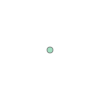

In [18]:
# What does a POINT() datum look like in a shapefile?
child_care['geometry'][0]

In [19]:
# The datatype is a shapely object
# It is important to remember that shapely objects can be points, lines, or polygons
type(child_care['geometry'][0])

shapely.geometry.point.Point

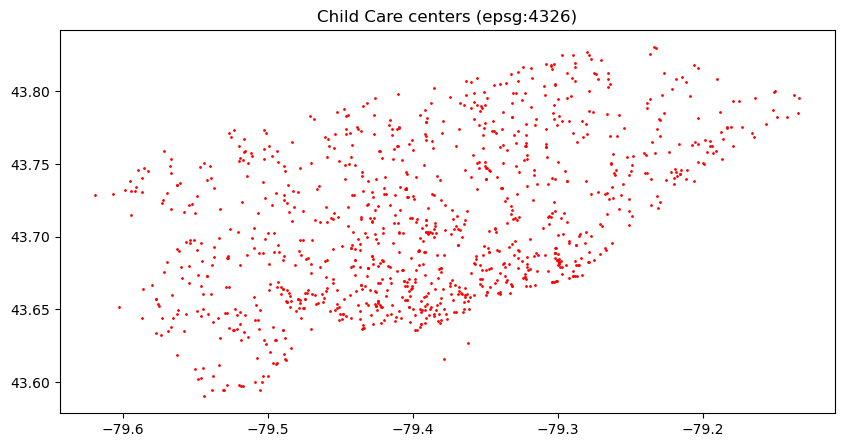

In [20]:
# Each shapely object is a point in space. Plotting the geopandas dataframe plots only the geometry column
# Each point represents a child care center in space. Already we can roughly see the shape of Toronto
ax = child_care.plot(figsize=(10, 10), color='red', markersize = 1)
ax.set_title('Child Care centers (epsg:4326)')
plt.show()

In [21]:
# Check the Coordinate Reference System out of curiosity
child_care['geometry'].crs

{'init': 'epsg:4326'}

In [22]:
# reprojecting epsg: 4326 to epsg:2019. This CRS seems to be preferable for the region of the earth we're representing
# See https://epsg.io/2019
# The bounds of representation are centered on Ontario
child_care = child_care.to_crs({'init': 'epsg:2019'})

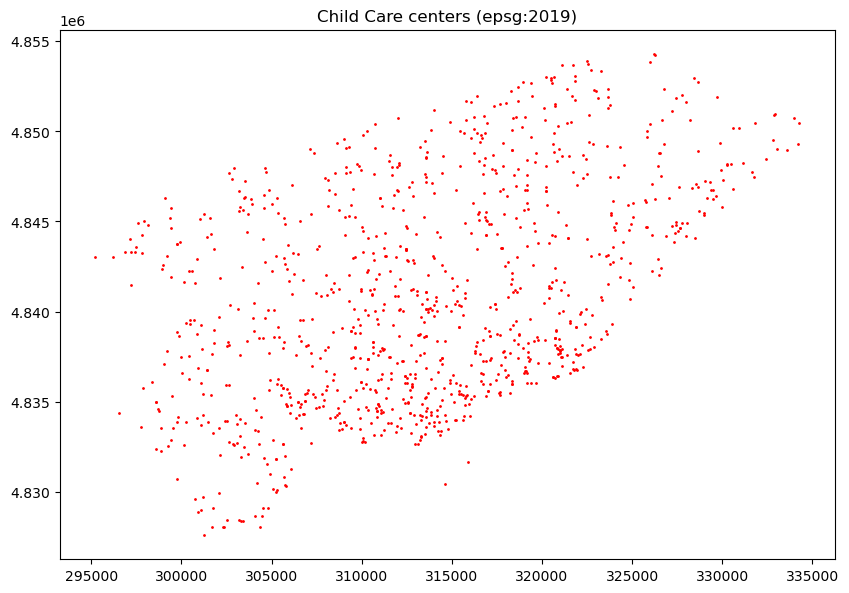

In [23]:
# After the reprojection the map seems like a more direct "top down" view
ax = child_care.plot(figsize=(10, 10), color='red', markersize = 1)
ax.set_title('Child Care centers (epsg:2019)')
plt.show()

In [24]:
# Isolate the longitude and lattitude numbers into x and y respectively
child_care['x'] = child_care.geometry.x
child_care['y'] = child_care.geometry.y
child_care.head()

_id  LOC_ID                                           LOC_NAME  \
0    1    1013              Lakeshore Community Child Care Centre   
1    2    1014            Alternative Primary School Parent Group   
2    3    1015     Cardinal Leger Child Care Centre (Scarborough)   
3    4    1016  George Brown - Richmond Adelaide Childcare Centre   
4    5    1017  Woodland Nursery School (Warden Woods Communit...   

             ADDRESS                        geometry              x  \
0     101 SEVENTH ST  POINT (304461.400 4828671.905)  304461.400215   
1    1100 SPADINA RD  POINT (311217.446 4840433.213)  311217.445605   
2     600 MORRISH RD  POINT (330918.335 4850204.630)  330918.335077   
3  130 ADELAIDE ST W  POINT (314172.949 4834207.161)  314172.948870   
4    1 FIRVALLEY CRT  POINT (322448.989 4840140.901)  322448.989348   

              y  
0  4.828672e+06  
1  4.840433e+06  
2  4.850205e+06  
3  4.834207e+06  
4  4.840141e+06

### Bring in the Address Data for the city of Toronto

In [26]:
# reading municipal address point shape file
# https://open.toronto.ca/dataset/address-points-municipal-toronto-one-address-repository/
# The One Address Repository data set provides a point representation for over 500,000 addresses within the City of Toronto.
address = gpd.read_file('zip://./raw_data/ADDRESS_POINT_WGS84.zip')
address.head()

GEO_ID     LINK MAINT_STAG ADDRESS           LFNAME  LO_NUM LONUMSUF  \
0  5729529  5729516    REGULAR     399   Lake Promenade     399     None   
1  9950585  9950578    REGULAR       7          Hilo Rd       7     None   
2  5729496  5729468    REGULAR     387   Lake Promenade     387     None   
3  5729341  5729332    REGULAR     321   Lake Promenade     321     None   
4  7304577  7304570    REGULAR      22  Thirty Sixth St      22     None   

   HINUM HINUMSUF ARC_SIDE  ...  CLASS  NAME           X            Y  \
0    NaN     None        L  ...   Land  None  301607.151  4827443.931   
1    NaN     None        L  ...   Land  None  301540.011  4827592.989   
2    NaN     None        L  ...   Land  None  301648.488  4827472.065   
3    NaN     None        L  ...   Land  None  301926.249  4827620.088   
4    NaN     None        L  ...   Land  None  301937.384  4827737.920   

   LONGITUDE   LATITUDE   OBJECTID   MUN_NAME            WARD_NAME  \
0 -79.539542  43.586930  1491585.0  Etobicoke  Etobicoke-Lakeshore   
1 -79.540374  43.588272  1491586.0  Etobicoke  Etobicoke-Lakeshore   
2 -79.539030  43.587184  1491591.0  Etobicoke  Etobicoke-Lakeshore   
3 -79.535591  43.588517  1491594.0  Etobicoke  Etobicoke-Lakeshore   
4 -79.535454  43.589578  1491597.0  Etobicoke  Etobicoke-Lakeshore   

                           geometry  
0  POINT (-8854300.947 5401738.297)  
1  POINT (-8854393.601 5401944.461)  
2  POINT (-8854243.981 5401777.244)  
3  POINT (-8853861.166 5401982.195)  
4  POINT (-8853845.885 5402145.216)  

[5 rows x 23 columns]

In [36]:
address.shape

(525452, 8)

In [27]:
# That's a lot of columns. Many of these will be irrelevant for us
address.columns

Index(['GEO_ID', 'LINK', 'MAINT_STAG', 'ADDRESS', 'LFNAME', 'LO_NUM',
       'LONUMSUF', 'HINUM', 'HINUMSUF', 'ARC_SIDE', 'DISTANCE', 'FCODE',
       'FCODE_DES', 'CLASS', 'NAME', 'X', 'Y', 'LONGITUDE', 'LATITUDE',
       'OBJECTID', 'MUN_NAME', 'WARD_NAME', 'geometry'],
      dtype='object')

In [28]:
# change column names from upper to lower case
address.columns = map(str.lower, address.columns)

# Keep only columns that we may need.
address = address[['address','lfname','x','y','objectid',
                   'mun_name','ward_name','geometry']]
address.head()

address           lfname           x            y   objectid   mun_name  \
0     399   Lake Promenade  301607.151  4827443.931  1491585.0  Etobicoke   
1       7          Hilo Rd  301540.011  4827592.989  1491586.0  Etobicoke   
2     387   Lake Promenade  301648.488  4827472.065  1491591.0  Etobicoke   
3     321   Lake Promenade  301926.249  4827620.088  1491594.0  Etobicoke   
4      22  Thirty Sixth St  301937.384  4827737.920  1491597.0  Etobicoke   

             ward_name                          geometry  
0  Etobicoke-Lakeshore  POINT (-8854300.947 5401738.297)  
1  Etobicoke-Lakeshore  POINT (-8854393.601 5401944.461)  
2  Etobicoke-Lakeshore  POINT (-8854243.981 5401777.244)  
3  Etobicoke-Lakeshore  POINT (-8853861.166 5401982.195)  
4  Etobicoke-Lakeshore  POINT (-8853845.885 5402145.216)

In [29]:
# Check the CRS for this geodataframe's shapely objects (i.e. the records in the geometry column) against the child care centers
# All CRS should agree with each other
child_care['geometry'].crs, address['geometry'].crs

({'init': 'epsg:2019'}, {'init': 'epsg:3857'})

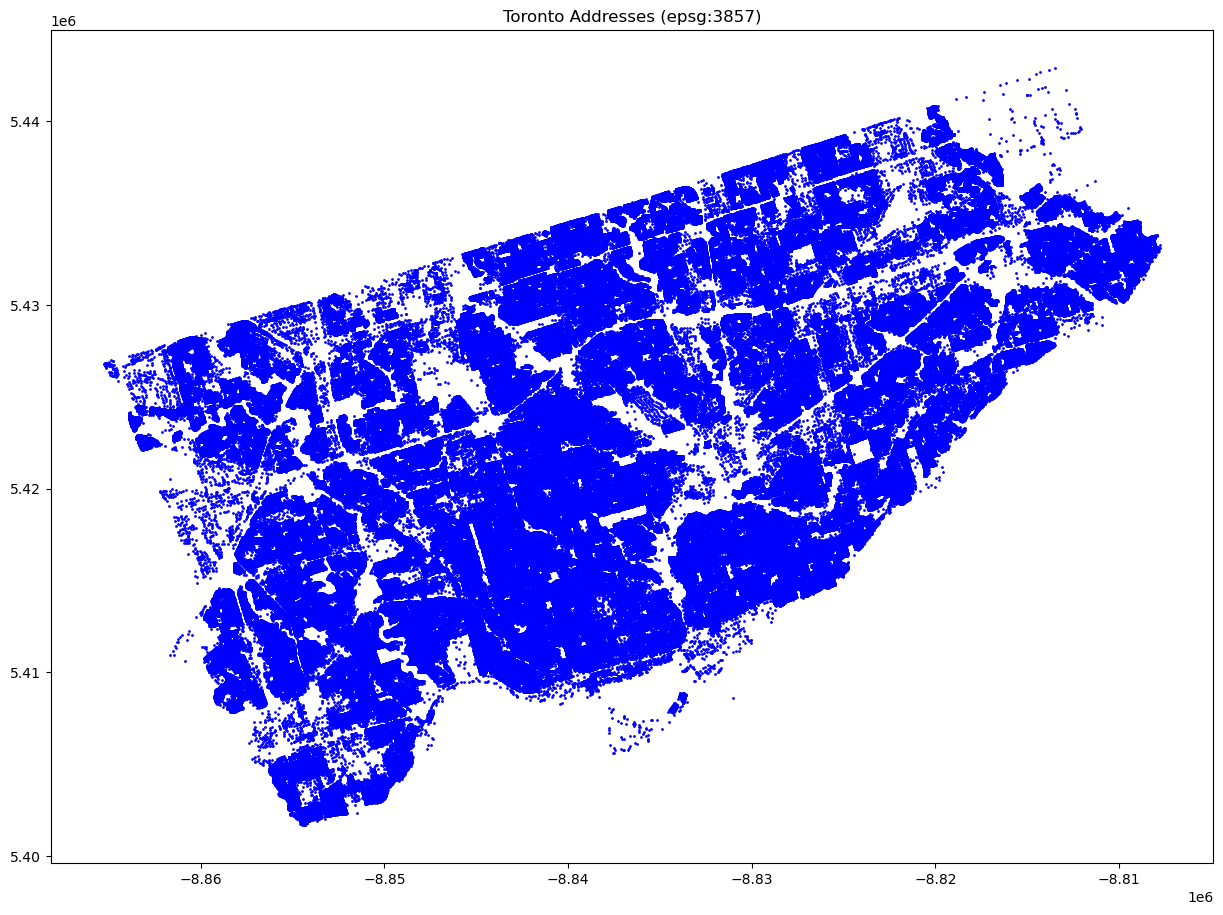

In [30]:
# What it looks like with original CRS
ax = address.plot(figsize=(15, 15),color='blue', markersize =1)
ax.set_title('Toronto Addresses (epsg:3857)')
plt.show()

In [31]:
# reprojecting epsg 3857 to epsg 4326
address = address.to_crs({'init': 'epsg:2019'})

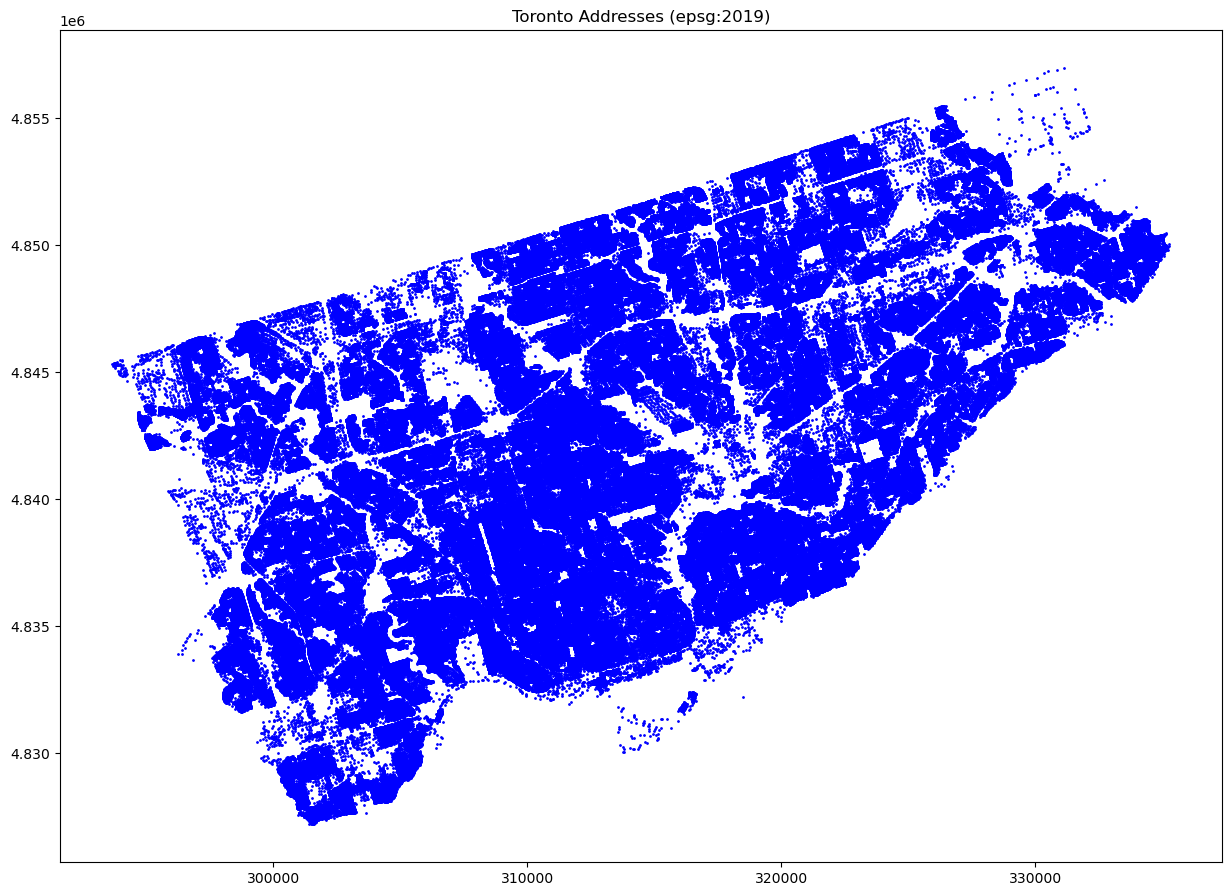

In [32]:
# What it looks like post transformation
# They look pretty much the same. Regardless, we will continue to reproject everything to epsg:2019 for consistency
ax = address.plot(figsize=(15, 15),color='blue', markersize =1)
ax.set_title('Toronto Addresses (epsg:2019)')
plt.show()

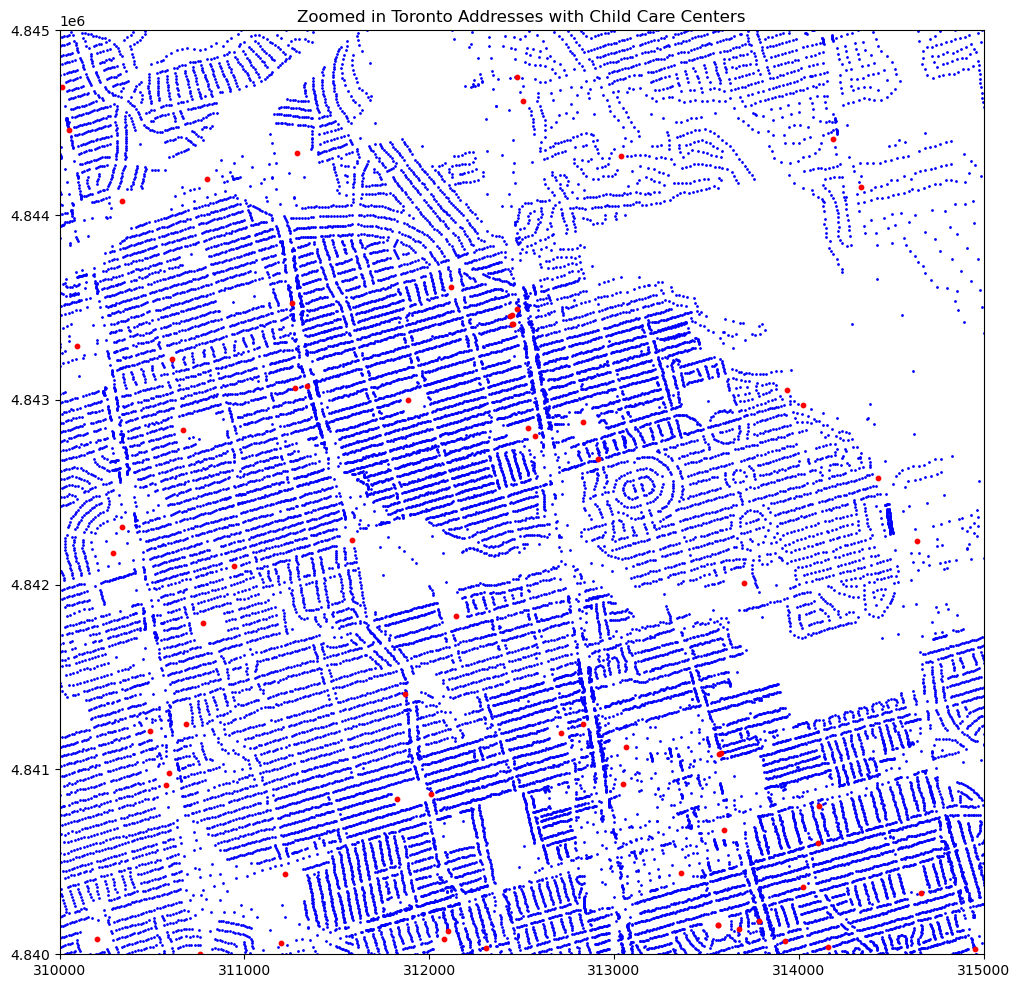

In [33]:
# Check out a zoomed in portion of the addresses with child care centers layered on
ax = address.plot(figsize=(12, 12),color='blue', markersize =1)
child_care.plot(ax=ax,color='red', markersize =10)
ax.set(xlim=(310000, 315000), ylim=(4840000, 4845000))
ax.set_title('Zoomed in Toronto Addresses with Child Care Centers')
plt.show()

# Read in the Pednet data. 

The Pedestrian Network (pednet) was created by the DAV team at the City of Toronto, and it is based on the sidewalk inventory from Transportation Services, Toronto road centrelines, and manual collection from aerial imagery. Pednet is integrated with centerline intersections, traffic signals, pedestrian crosswalks and crossovers, traffic signal data from Transportation Services as well as other City of Toronto datasets. https://open.toronto.ca/dataset/pedestrian-network/

We need the Pednet data here to be the lines that connect our nodes (the child care centers and addresses).

In [62]:
pednet = gpd.read_file('zip://./raw_data/Pedestrian Network Data - 4326.zip')
pednet = pednet.to_crs({'init': 'epsg:2019'})
pednet.crs

{'init': 'epsg:2019'}

In [72]:
pednet.head()

FIELD_1  FIELD_2    FIELD_3  FIELD_4                      FIELD_5  FIELD_6  \
0        1        1      Local      7.0       Sidewalk on both sides      NaN   
1        2        2  Collector      7.0       Sidewalk on both sides      NaN   
2        3        3       None      2.0  Sidewalk on north side only      NaN   
3        4        4       None      7.0       Sidewalk on both sides      NaN   
4        5        5      Local      7.0       Sidewalk on both sides      NaN   

  FIELD_7 FIELD_8 FIELD_9    FIELD_10  \
0    None    None    None   93.867680   
1    None    None    None   32.546284   
2    None    None    None  117.669206   
3    None    None    None  223.269710   
4    None    None    None  201.335648   

                                            geometry  
0  LINESTRING (299647.480 4843993.305, 299730.645...  
1  LINESTRING (299319.487 4832701.797, 299351.915...  
2  LINESTRING (314644.016 4837403.152, 314756.028...  
3  LINESTRING (303307.301 4840346.899, 303450.851...  
4  LINESTRING (320802.305 4848122.923, 320996.750...

In [73]:
# Replace uninformative column names with correct column titles taken from the above link
pednet_column_names = ['_id', 'OBJECTID', 'ROAD_TYPE', 'SIDEWALK_CODE', 'SIDEWALK_DESCRIPTION', 'CROSSWALK', 'CROSSWALK_TYPE', 
                       'PX', 'PX_TYPE', 'LENGTH', 'geometry']
mapper = dict(zip(list(pednet.columns), pednet_column_names))
pednet.rename(mapper = mapper, axis = 1, inplace = True)
pednet.head()

_id  OBJECTID  ROAD_TYPE  SIDEWALK_CODE         SIDEWALK_DESCRIPTION  \
0    1         1      Local            7.0       Sidewalk on both sides   
1    2         2  Collector            7.0       Sidewalk on both sides   
2    3         3       None            2.0  Sidewalk on north side only   
3    4         4       None            7.0       Sidewalk on both sides   
4    5         5      Local            7.0       Sidewalk on both sides   

   CROSSWALK CROSSWALK_TYPE    PX PX_TYPE      LENGTH  \
0        NaN           None  None    None   93.867680   
1        NaN           None  None    None   32.546284   
2        NaN           None  None    None  117.669206   
3        NaN           None  None    None  223.269710   
4        NaN           None  None    None  201.335648   

                                            geometry  
0  LINESTRING (299647.480 4843993.305, 299730.645...  
1  LINESTRING (299319.487 4832701.797, 299351.915...  
2  LINESTRING (314644.016 4837403.152, 314756.028...  
3  LINESTRING (303307.301 4840346.899, 303450.851...  
4  LINESTRING (320802.305 4848122.923, 320996.750...

In [74]:
pednet.shape

(87105, 11)

In [75]:
# Check missing values
len(pednet), pednet.isna().sum()

(87105,
 _id                         0
 OBJECTID                    0
 ROAD_TYPE                 790
 SIDEWALK_CODE            1421
 SIDEWALK_DESCRIPTION     2696
 CROSSWALK               77798
 CROSSWALK_TYPE          77797
 PX                      79479
 PX_TYPE                 79479
 LENGTH                      0
 geometry                    0
 dtype: int64)

In [76]:
# Drop the columns with over 70k missing values
# Drop other irrelevant columns
pednet.drop(columns = ['CROSSWALK_TYPE', 'PX', 'PX_TYPE', 'SIDEWALK_CODE', 'LENGTH'], inplace = True)
# Rename columns to all be lower case
pednet.columns = map(str.lower, pednet.columns)
pednet.head()

_id  objectid  road_type         sidewalk_description  crosswalk  \
0    1         1      Local       Sidewalk on both sides        NaN   
1    2         2  Collector       Sidewalk on both sides        NaN   
2    3         3       None  Sidewalk on north side only        NaN   
3    4         4       None       Sidewalk on both sides        NaN   
4    5         5      Local       Sidewalk on both sides        NaN   

                                            geometry  
0  LINESTRING (299647.480 4843993.305, 299730.645...  
1  LINESTRING (299319.487 4832701.797, 299351.915...  
2  LINESTRING (314644.016 4837403.152, 314756.028...  
3  LINESTRING (303307.301 4840346.899, 303450.851...  
4  LINESTRING (320802.305 4848122.923, 320996.750...

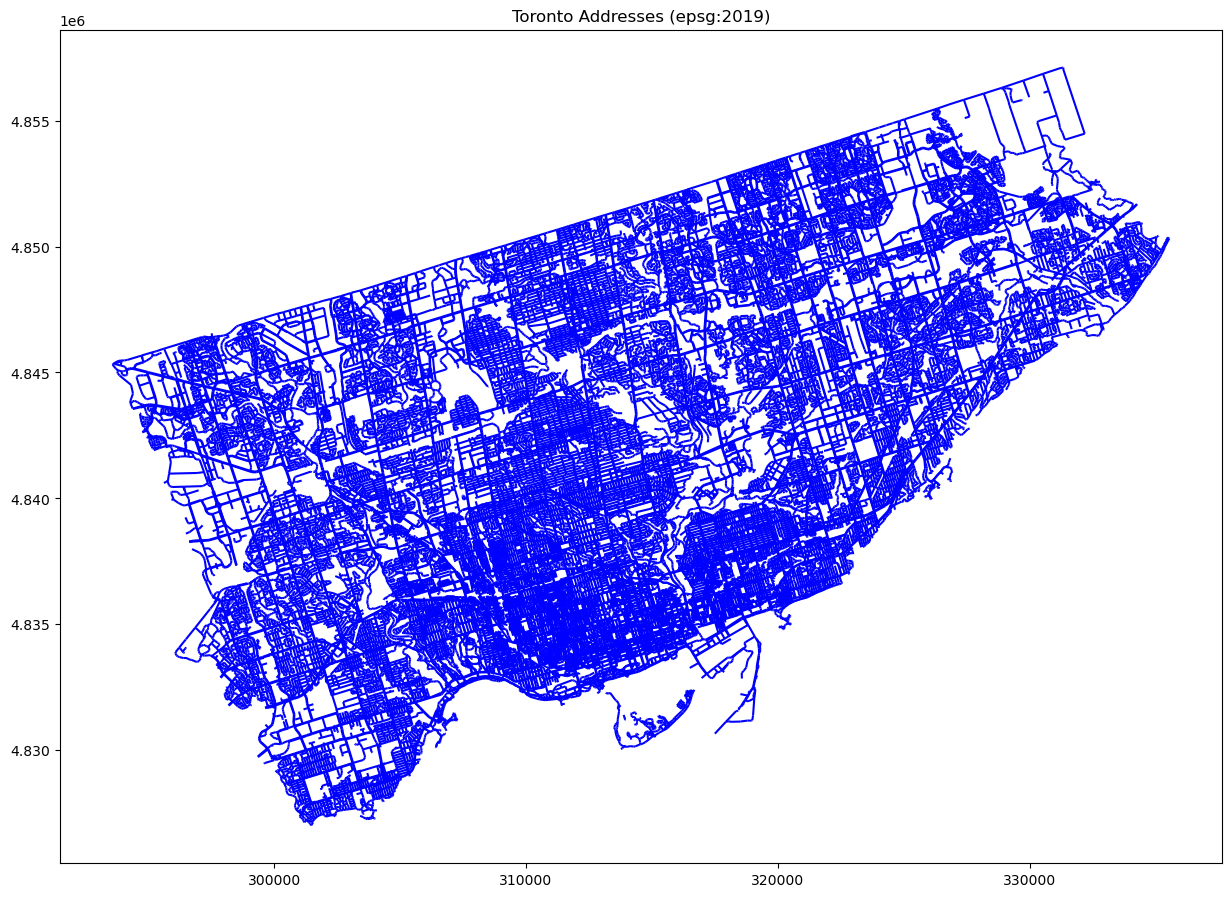

In [77]:
# Look at the pednet plot
ax = pednet.plot(figsize=(15, 15),color='blue', markersize =1)
ax.set_title('Toronto Addresses (epsg:2019)')
plt.show()

### Toronto Wards

We bring in the Wards of Toronto so that users can better understand how the different wards of Toronto fare in terms of proximity to child care centers.

In [78]:
# reading Toronto Wards shapefile
# https://open.toronto.ca/dataset/city-wards/
wards = gpd.read_file('zip://./raw_data//WARD_WGS84.zip')
wards.head(3)

AREA_ID AREA_TYPE AREA_S_CD AREA_L_CD            AREA_NAME           X  \
0  2551040      WD18        16        16      Don Valley East  318237.290   
1  2551044      WD18        03        03  Etobicoke-Lakeshore  303099.474   
2  2551048      WD18        15        15      Don Valley West  314825.876   

           Y  LONGITUDE   LATITUDE  \
0  4844000.0  -79.33298  43.739716   
1  4831000.0  -79.52087  43.621646   
2  4843000.0  -79.37536  43.728396   

                                            geometry  
0  POLYGON ((-79.31335 43.71699, -79.31950 43.715...  
1  POLYGON ((-79.49777 43.65198, -79.49725 43.651...  
2  POLYGON ((-79.35232 43.71573, -79.35209 43.715...

In [79]:
# change column names from upper to lower case
wards.columns = map(str.lower, wards.columns)

#include columns needed for the project
wards = wards[['area_id','area_s_cd','area_name','geometry']]
wards.head(3)

area_id area_s_cd            area_name  \
0  2551040        16      Don Valley East   
1  2551044        03  Etobicoke-Lakeshore   
2  2551048        15      Don Valley West   

                                            geometry  
0  POLYGON ((-79.31335 43.71699, -79.31950 43.715...  
1  POLYGON ((-79.49777 43.65198, -79.49725 43.651...  
2  POLYGON ((-79.35232 43.71573, -79.35209 43.715...

In [80]:
wards.crs

{'init': 'epsg:4326'}

In [81]:
# reprojecting epsg 4386 (wgs84) to epsg 2019 (mtm nad 27)
wards = wards.to_crs({'init': 'epsg:2019'})
wards.crs

{'init': 'epsg:2019'}

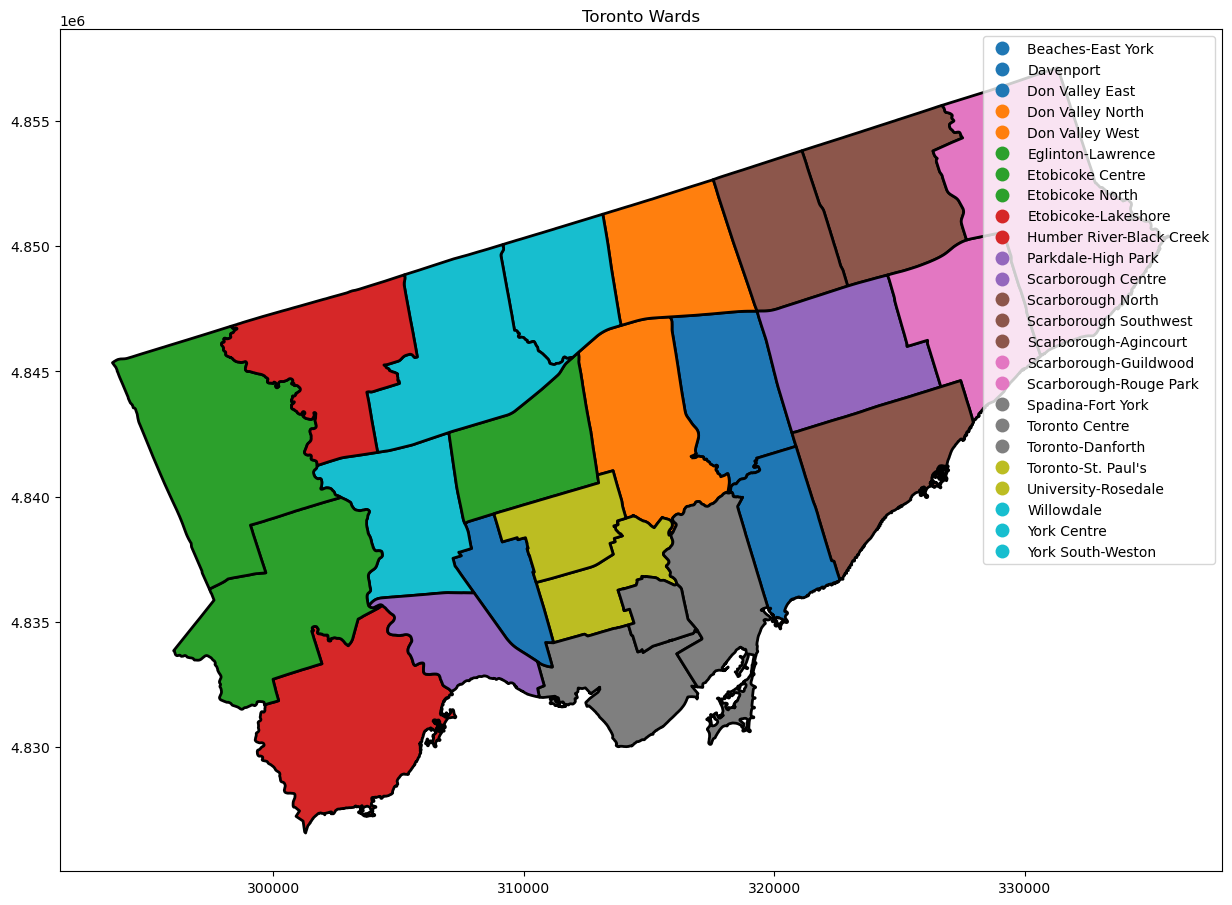

In [82]:
# plot Wards
ax = wards.plot(figsize=(15, 15), column='area_name',edgecolor='black', linewidth=2, legend = True)
plt.title('Toronto Wards')
plt.show()

### Bring in Function to Facilitate Distance Calculations

In [83]:
# creating network graph code
def create_graph(gdf, precision=3):
    '''Create a networkx given a GeoDataFrame of lines. Every line will
    correspond to two directional graph edges, one forward, one reverse. The
    original line row and direction will be stored in each edge. Every node
    will be where endpoints meet (determined by being very close together) and
    will store a clockwise ordering of incoming edges.
    '''
      
    G = nx.Graph()

    def make_node(coord, precision):
        return tuple(np.round(coord, precision))

    # Edges are stored as (from, to, data), where from and to are nodes.
    def add_edges(row, G):
        geometry = row.geometry
        coords = list(geometry.coords)
        geom_r = LineString(coords[::-1])
        coords_r = geom_r.coords
        start = make_node(coords[0], precision)
        end = make_node(coords[-1], precision)
        # Add forward edge
        fwd_attr ={}
        for k,v in row.items():
            fwd_attr[k]=v
        fwd_attr['forward']= 1
       #fwd_attr['geometry']=  geometry
        fwd_attr['length']=  geometry.length

        fwd_attr['visited']= 0

        G.add_edge(start, end, **fwd_attr)

    gdf.apply(add_edges, axis=1, args=[G])

    return G

In [84]:
graph = create_graph(pednet)

In [85]:
# get network "from" and "to" from nodes
edges = nx.to_pandas_edgelist(graph,'from','to')
to = edges['to'].tolist()
fr = edges['from'].tolist()
fr = list(set(fr))
to = list(set(to))
to.extend(fr)
nodes = list(set(to))
nodes = pd.DataFrame(nodes)
nodes.columns=['x', 'y']
nodes['xy'] = nodes.apply(lambda z: (z.x,z.y),axis=1)

In [86]:
# Assigning node ids to to_node and from_node

nodes['id'] = nodes.index
edges['to_node']=edges['to'].map(nodes.set_index('xy').id)
edges['from_node']=edges['from'].map(nodes.set_index('xy').id)
edges.head(3)

from                         to  objectid  crosswalk  \
0   (299647.48, 4843993.305)  (299730.645, 4843949.766)         1        NaN   
1   (299647.48, 4843993.305)   (299602.64, 4844063.116)     84099        NaN   
2  (299730.645, 4843949.766)   (299811.934, 4843907.77)     25712        NaN   

      length    _id                                           geometry  \
0  93.871829      1  LINESTRING (299647.4801773648 4843993.30454858...   
1  82.971471  84099  LINESTRING (299602.6398887987 4844063.11581879...   
2  91.496355  25712  LINESTRING (299730.6445645975 4843949.76600211...   

   forward  visited road_type        sidewalk_description  to_node  from_node  
0        1        0     Local      Sidewalk on both sides    31303      60732  
1        1        0     Local      Sidewalk on both sides     5980      60732  
2        1        0     Local  No sidewalk on either side    35031      31303

# Creating the Pandana Network

In [87]:
ped_net = pdna.Network(nodes["x"],
                       nodes["y"],
                       edges["from_node"],
                       edges["to_node"],
                       pd.DataFrame([edges['length']]).T,
                       twoway=True)

In [88]:
#precompute a given horizon distance of 1000 meters
ped_net.precompute(1000)
ped_net.edges_df.head()

from     to     length
0  60732  31303  93.871829
1  60732   5980  82.971471
2  31303  35031  91.496355
3  31303  43121  98.813743
4    452  37481  32.547298

In [89]:
#get node_ids for points for each layer
x, y = child_care.x, child_care.y 
child_care["node_ids"] = ped_net.get_node_ids(x, y)
ped_net.set(child_care["node_ids"], name="child_care_center")

# using x and y coordinates from address that are utm nad27 
x, y = address.x, address.y
address["node_ids"] = ped_net.get_node_ids(x, y)

In [90]:
#get nearest points with id
n=10
maxdistance = 5000

ped_net.set_pois("child_care_center", maxdistance , n, child_care.x, child_care.y)
child_care_walk_distances = ped_net.nearest_pois(maxdistance , "child_care_center", num_pois=n, include_poi_ids=False)

child_care_walk_distances.head(3)

1            2            3            4            5   \
0  1517.104004  1545.187988  1596.000977  1723.125977  1879.307983   
1   506.835999  1217.880981  1274.965942  1278.350952  1335.120972   
2   394.247986   723.539001   738.403015   900.098999   900.098999   

            6            7            8            9            10  
0  1890.005005  1904.427979  1914.000000  2127.676025  2334.210938  
1  1429.837036  1469.095947  1601.531006  1681.581055  1769.709961  
2  1270.192993  1437.305054  2104.792969  2252.302979  2258.416992

In [91]:
child_care_walk_distances.head(10)

1            2            3            4            5   \
0  1517.104004  1545.187988  1596.000977  1723.125977  1879.307983   
1   506.835999  1217.880981  1274.965942  1278.350952  1335.120972   
2   394.247986   723.539001   738.403015   900.098999   900.098999   
3   295.927002   708.801025   731.557983  1034.579956  1079.435059   
4   379.239014   434.165985   710.406006   771.268005   778.705994   
5   473.997009   926.703979  1079.609985  1249.843018  1361.338013   
6   369.846008   414.184998   651.637024   804.333008   874.692017   
7   543.606018   912.497986  1215.005981  1239.956055  1414.595947   
8   419.653992   876.486023  1037.093018  1052.598999  1581.097046   
9   389.153992   664.867004   671.065002   771.346008  1039.771973   

            6            7            8            9            10  
0  1890.005005  1904.427979  1914.000000  2127.676025  2334.210938  
1  1429.837036  1469.095947  1601.531006  1681.581055  1769.709961  
2  1270.192993  1437.305054  2104.792969  2252.302979  2258.416992  
3  1086.435059  1558.167969  1614.343018  1693.980957  1850.270020  
4   795.340027   806.716003   807.435974  1164.087036  1173.227051  
5  1362.897949  1474.631958  1539.311035  1546.109985  1623.661987  
6   977.656982  1175.771973  1184.286011  1198.692993  1277.365967  
7  1438.292969  1465.214966  1580.494019  1681.957031  1687.478027  
8  1665.265015  1791.182007  2160.622070  2266.595947  2355.589111  
9  1463.958008  1597.828003  2019.103027  2045.954956  2049.955078

In [92]:
# Rename columns 1 to 10 to d_ttcstop_0 to d_ttcstop_9.

n=10

columns =  ['child_care_center'+str(i) for i in range(0,n,1)]

child_care_walk_distances.columns = columns
child_care_walk_distances.head(2)

child_care_center0  child_care_center1  child_care_center2  \
0         1517.104004         1545.187988         1596.000977   
1          506.835999         1217.880981         1274.965942   

   child_care_center3  child_care_center4  child_care_center5  \
0         1723.125977         1879.307983         1890.005005   
1         1278.350952         1335.120972         1429.837036   

   child_care_center6  child_care_center7  child_care_center8  \
0         1904.427979         1914.000000         2127.676025   
1         1469.095947         1601.531006         1681.581055   

   child_care_center9  
0         2334.210938  
1         1769.709961

In [93]:
for i in range(10):
    address['d_child_care_center{}'.format(i)]=address['node_ids'].map(child_care_walk_distances['child_care_center{}'.format(i)])
address.head(3)

address          lfname           x            y   objectid   mun_name  \
0     399  Lake Promenade  301607.151  4827443.931  1491585.0  Etobicoke   
1       7         Hilo Rd  301540.011  4827592.989  1491586.0  Etobicoke   
2     387  Lake Promenade  301648.488  4827472.065  1491591.0  Etobicoke   

             ward_name                        geometry  node_ids  \
0  Etobicoke-Lakeshore  POINT (301607.060 4827228.149)     59760   
1  Etobicoke-Lakeshore  POINT (301539.918 4827377.205)     61597   
2  Etobicoke-Lakeshore  POINT (301648.398 4827256.282)     59760   

   d_child_care_center0  d_child_care_center1  d_child_care_center2  \
0            525.765991            805.987976           1215.489014   
1            414.541992            615.520020           1025.020996   
2            525.765991            805.987976           1215.489014   

   d_child_care_center3  d_child_care_center4  d_child_care_center5  \
0           1518.217041           1788.779053           1888.009033   
1           1327.749023           1598.311035           1697.541016   
2           1518.217041           1788.779053           1888.009033   

   d_child_care_center6  d_child_care_center7  d_child_care_center8  \
0           2183.667969           2301.128906           2309.674072   
1           1993.199951           2110.660889           2119.206055   
2           2183.667969           2301.128906           2309.674072   

   d_child_care_center9  
0           2394.002930  
1           2203.534912  
2           2394.002930

In [94]:
# Calculate minutes fields based on distances. This cell takes 1.5 minutes to run.

address['m_child_care_0'] = address.apply(lambda row: row.d_child_care_center0/(1.2*60), axis=1)
address['m_child_care_1'] = address.apply(lambda row: row.d_child_care_center1/(1.2*60), axis=1)
address['m_child_care_2'] = address.apply(lambda row: row.d_child_care_center2/(1.2*60), axis=1)
address['m_child_care_3'] = address.apply(lambda row: row.d_child_care_center3/(1.2*60), axis=1)
address['m_child_care_4'] = address.apply(lambda row: row.d_child_care_center4/(1.2*60), axis=1)
address['m_child_care_5'] = address.apply(lambda row: row.d_child_care_center5/(1.2*60), axis=1)
address['m_child_care_6'] = address.apply(lambda row: row.d_child_care_center6/(1.2*60), axis=1)
address['m_child_care_7'] = address.apply(lambda row: row.d_child_care_center7/(1.2*60), axis=1)
address['m_child_care_8'] = address.apply(lambda row: row.d_child_care_center8/(1.2*60), axis=1)
address['m_child_care_9'] = address.apply(lambda row: row.d_child_care_center9/(1.2*60), axis=1)
address.head(3)

address          lfname           x            y   objectid   mun_name  \
0     399  Lake Promenade  301607.151  4827443.931  1491585.0  Etobicoke   
1       7         Hilo Rd  301540.011  4827592.989  1491586.0  Etobicoke   
2     387  Lake Promenade  301648.488  4827472.065  1491591.0  Etobicoke   

             ward_name                        geometry  node_ids  \
0  Etobicoke-Lakeshore  POINT (301607.060 4827228.149)     59760   
1  Etobicoke-Lakeshore  POINT (301539.918 4827377.205)     61597   
2  Etobicoke-Lakeshore  POINT (301648.398 4827256.282)     59760   

   d_child_care_center0  ...  m_child_care_0  m_child_care_1  m_child_care_2  \
0            525.765991  ...        7.302305       11.194277       16.881792   
1            414.541992  ...        5.757528        8.548889       14.236403   
2            525.765991  ...        7.302305       11.194277       16.881792   

   m_child_care_3  m_child_care_4  m_child_care_5  m_child_care_6  \
0       21.086348       24.844154       26.222348       30.328722   
1       18.440959       22.198764       23.576959       27.683333   
2       21.086348       24.844154       26.222348       30.328722   

   m_child_care_7  m_child_care_8  m_child_care_9  
0       31.960124       32.078807       33.250041  
1       29.314735       29.433417       30.604652  
2       31.960124       32.078807       33.250041  

[3 rows x 29 columns]

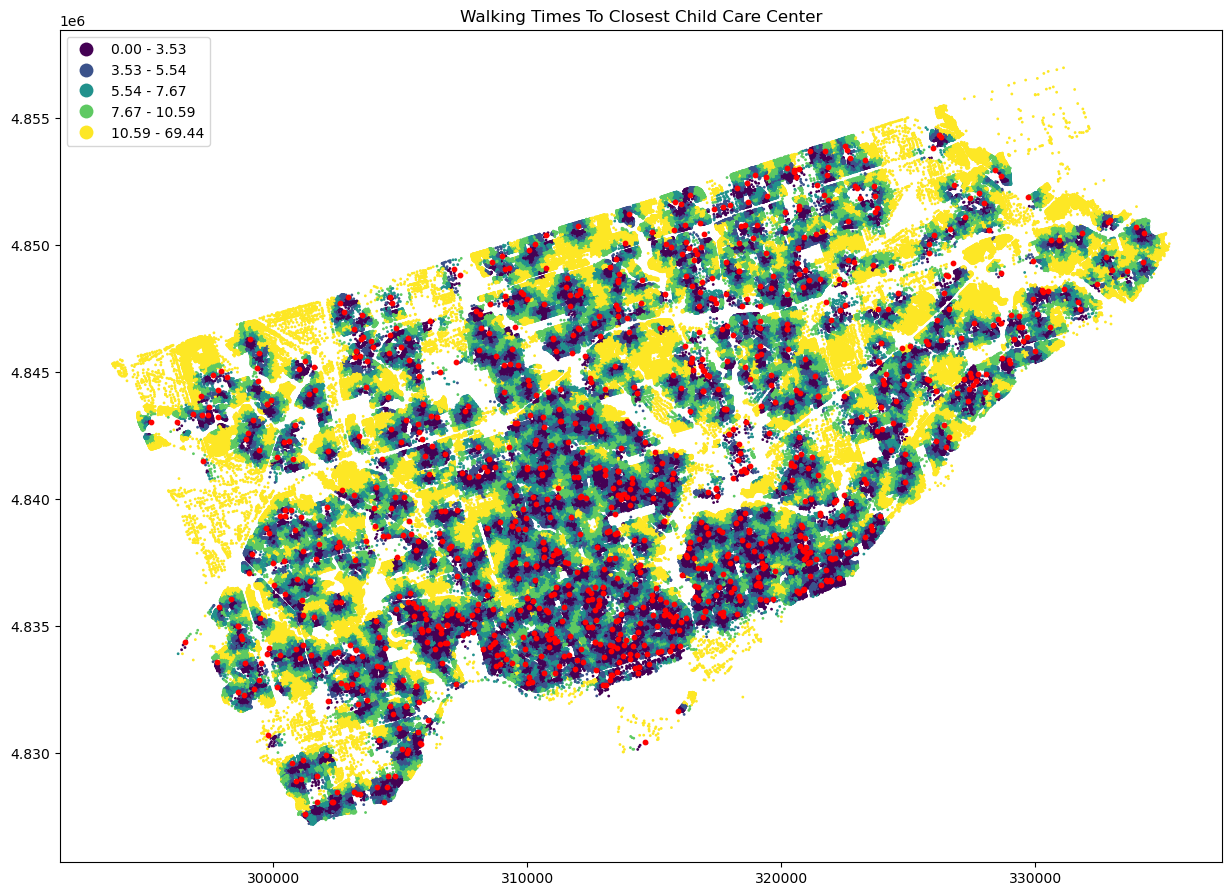

In [98]:
# Walking times To closest child care center

ax = address.plot(figsize=(15, 15), column='m_child_care_0', scheme='quantiles', legend=True,markersize = 1)
child_care.plot(ax=ax, color='red', markersize =10)
plt.title('Walking Times To Closest Child Care Center')

plt.show()
plt.savefig('walking_times_ccc.png')

### Walking Times To Child Care Center with Wards

In this step we will invesitgate the walk times in the Wards.

### Get the Ward center points

To place a label on each Ward in the plot we need to find an identifiable point which exists within each polygon so that we can say where we want the text to be placed.

In [99]:
# Here we find the center points, copy our original df to a new df, and then set 
# the geometry column to the newly created center points column 
# (because a GeoPandas df can only have one geometry column)
wards["center"] = wards["geometry"].centroid
wards_points = wards.copy()
wards_points.set_geometry("center", inplace = True)

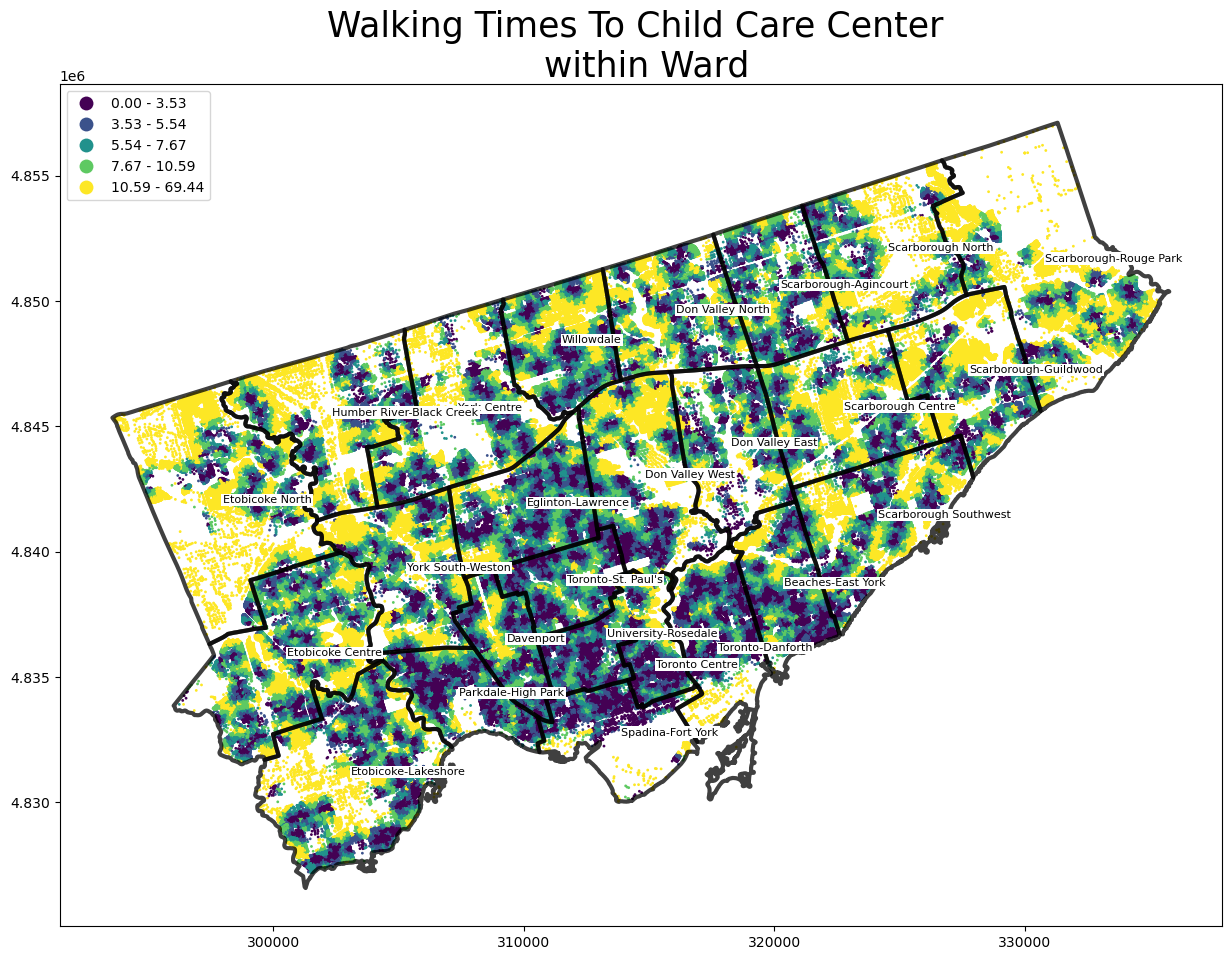

<Figure size 640x480 with 0 Axes>

In [100]:
# ploting and adding labels for Wards
ax = address.plot(figsize=(15, 15), column='m_child_care_0', scheme='quantiles', legend=True,markersize = 1)
wards.plot(ax=ax, edgecolor='black', facecolor= 'none', linewidth=3, alpha=0.75)
texts = []

# Plot labels and add a white box behind the label using the matplotlib bbox class.
for x, y, label in zip(wards_points.geometry.x, wards_points.geometry.y, wards_points["area_name"]):
    texts.append(plt.text(x, y, label, fontsize = 8, bbox=dict(boxstyle='square,pad=0.1', fc='white', ec='none')))

ax.set_title('Walking Times To Child Care Center \n within Ward', fontdict={'fontsize': '25', 'fontweight' : '3'})

plt.show()
plt.savefig("./walking_times_ccc_wards.png")

### Addresses within Wards

We will now perform a spatial join between the ward layer and address layer in order to allocate addresses to the wards.

In [101]:
# Spatial Join where Ward polygons are intersected with address points
ward_address = gpd.sjoin(wards, address, op='intersects', how='left')
ward_address.head(2)

area_id area_s_cd        area_name  \
0  2551040        16  Don Valley East   
0  2551040        16  Don Valley East   

                                            geometry  \
0  POLYGON ((319840.765 4841693.607, 319344.982 4...   
0  POLYGON ((319840.765 4841693.607, 319344.982 4...   

                           center  index_right address         lfname  \
0  POINT (318253.418 4844215.439)       382855     127  Farm Greenway   
0  POINT (318253.418 4844215.439)       382850     107  Farm Greenway   

            x            y  ...  m_child_care_0 m_child_care_1 m_child_care_2  \
0  319346.229  4847326.034  ...        8.736805      10.361792      11.869111   
0  319339.910  4847352.866  ...       10.162820      12.217972      13.842958   

   m_child_care_3  m_child_care_4  m_child_care_5  m_child_care_6  \
0       12.229750       17.964486       18.679930       18.854167   
0       15.710917       16.809458       17.213972       17.472944   

   m_child_care_7  m_child_care_8  m_child_care_9  
0       19.189846       19.189846       20.055237  
0       20.419820       20.606959       20.705041  

[2 rows x 34 columns]

### Count of addresses in wards

We will now do a count of addresses within each ward and visualize the results in a bar plot.

In [102]:
# count of addresses assigned to each ward
value_counts = ward_address.area_name.value_counts()
value_counts

Toronto-Danforth            30858
Etobicoke-Lakeshore         29104
Davenport                   28761
Beaches-East York           28732
Eglinton-Lawrence           26116
Scarborough-Rouge Park      25701
Etobicoke Centre            25584
Scarborough Southwest       24774
York South-Weston           23352
Parkdale-High Park          22969
Don Valley West             21935
University-Rosedale         21925
Scarborough Centre          20012
Scarborough North           19827
Toronto-St. Paul's          19506
Etobicoke North             18785
York Centre                 18714
Don Valley North            18463
Willowdale                  18440
Humber River-Black Creek    17903
Scarborough-Guildwood       16744
Scarborough-Agincourt       16653
Don Valley East             11071
Spadina-Fort York           10341
Toronto Centre               9182
Name: area_name, dtype: int64

In [103]:
# count of addresses assigned to each ward
value_counts = ward_address.area_name.value_counts()
value_counts

# renaming axixs to area_name and resetting index to ward_address_count
ward_address_counts = value_counts.rename_axis('area_name').reset_index(name='ward_address_count')
ward_address_counts

# merge ward_address_counts with ward_address using the area_name which is shared by both dataframes
ward_address = pd.merge(ward_address, ward_address_counts)

ward_address.head(2)

area_id area_s_cd        area_name  \
0  2551040        16  Don Valley East   
1  2551040        16  Don Valley East   

                                            geometry  \
0  POLYGON ((319840.765 4841693.607, 319344.982 4...   
1  POLYGON ((319840.765 4841693.607, 319344.982 4...   

                           center  index_right address         lfname  \
0  POINT (318253.418 4844215.439)       382855     127  Farm Greenway   
1  POINT (318253.418 4844215.439)       382850     107  Farm Greenway   

            x            y  ...  m_child_care_1 m_child_care_2 m_child_care_3  \
0  319346.229  4847326.034  ...       10.361792      11.869111      12.229750   
1  319339.910  4847352.866  ...       12.217972      13.842958      15.710917   

   m_child_care_4  m_child_care_5  m_child_care_6  m_child_care_7  \
0       17.964486       18.679930       18.854167       19.189846   
1       16.809458       17.213972       17.472944       20.419820   

   m_child_care_8  m_child_care_9  ward_address_count  
0       19.189846       20.055237               11071  
1       20.606959       20.705041               11071  

[2 rows x 35 columns]

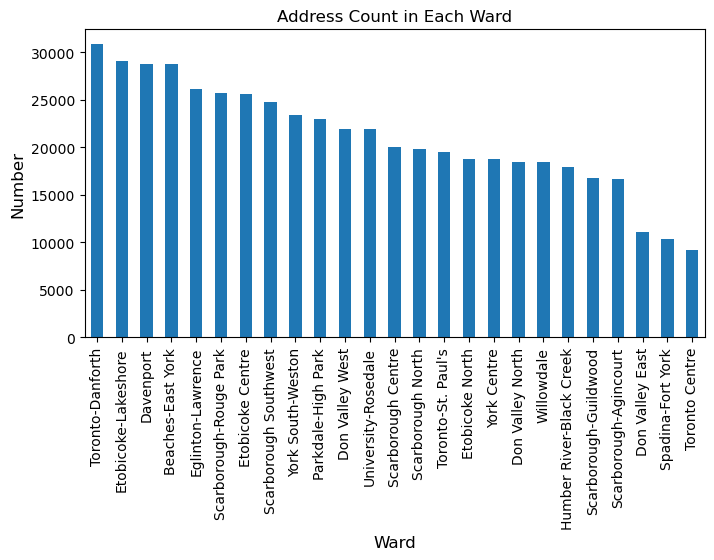

In [104]:
# distribution of addresses in wards

#plot
plt.figure(figsize=(8,4))

plt.title("Address Count in Each Ward")
plt.ylabel('Number', fontsize=12)
plt.xlabel('Ward', fontsize=12)

ward_address.area_name.value_counts().plot.bar()
plt.show()

### Average Walking Times To Closest Child Care Center in the Wards

We will now use the mean function to calculate the mean walking time to the closest Child Care Center for each of the Wards.

In [105]:
mins_avgs = ward_address.groupby('area_name')['m_child_care_0'].mean().sort_values()
mins_avgs

area_name
Spadina-Fort York            4.439700
Toronto Centre               4.522810
Toronto-Danforth             4.933180
Toronto-St. Paul's           5.331901
Parkdale-High Park           5.336657
University-Rosedale          5.498361
Davenport                    6.013304
Beaches-East York            6.014118
Eglinton-Lawrence            6.185578
Scarborough-Agincourt        6.702102
Etobicoke-Lakeshore          7.001561
Don Valley East              7.176950
York Centre                  7.466735
Don Valley West              7.648101
Scarborough Southwest        7.717035
Don Valley North             7.940300
Willowdale                   7.980727
Etobicoke Centre             8.111973
Scarborough Centre           8.490966
York South-Weston            8.707921
Humber River-Black Creek     8.960450
Scarborough North            9.428760
Scarborough-Guildwood       10.452935
Scarborough-Rouge Park      11.055530
Etobicoke North             12.132979
Name: m_child_care_0, dtype: float64

In [106]:
# renaming axixs to area_name and resetting index to ward_addr_avg_min
ward_addr_avg_min = mins_avgs.rename_axis('area_name').reset_index(name='ward_addr_avg_min')
ward_addr_avg_min

# merge nia_address with ward_addr_avg_min using area_name
ward_address = pd.merge(ward_address, ward_addr_avg_min)

ward_address.head(2)

area_id area_s_cd        area_name  \
0  2551040        16  Don Valley East   
1  2551040        16  Don Valley East   

                                            geometry  \
0  POLYGON ((319840.765 4841693.607, 319344.982 4...   
1  POLYGON ((319840.765 4841693.607, 319344.982 4...   

                           center  index_right address         lfname  \
0  POINT (318253.418 4844215.439)       382855     127  Farm Greenway   
1  POINT (318253.418 4844215.439)       382850     107  Farm Greenway   

            x            y  ...  m_child_care_2 m_child_care_3 m_child_care_4  \
0  319346.229  4847326.034  ...       11.869111      12.229750      17.964486   
1  319339.910  4847352.866  ...       13.842958      15.710917      16.809458   

   m_child_care_5  m_child_care_6  m_child_care_7  m_child_care_8  \
0       18.679930       18.854167       19.189846       19.189846   
1       17.213972       17.472944       20.419820       20.606959   

   m_child_care_9  ward_address_count  ward_addr_avg_min  
0       20.055237               11071            7.17695  
1       20.705041               11071            7.17695  

[2 rows x 36 columns]

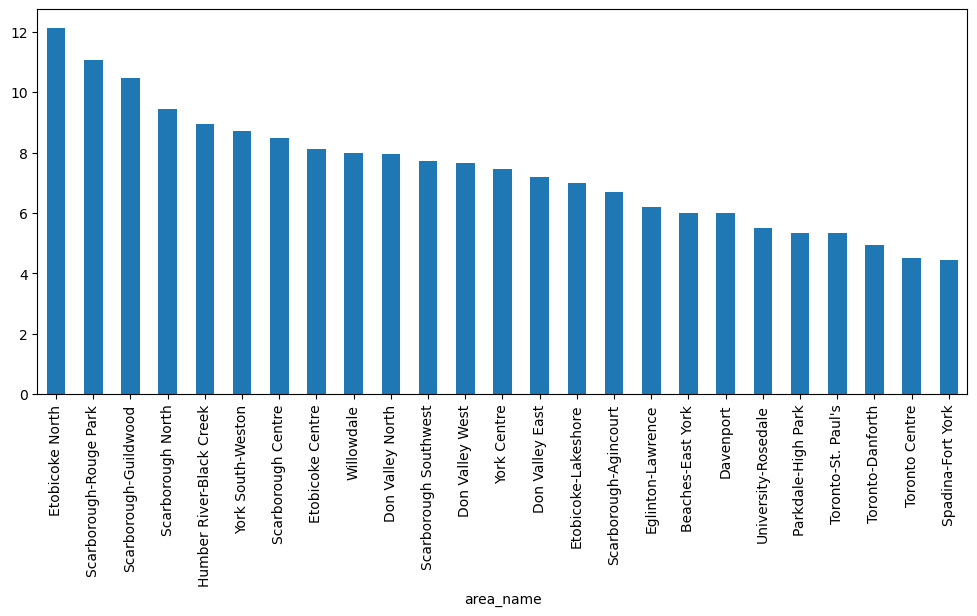

In [107]:
# plot bar plot
plt.figure(figsize=(12,5))
ward_address_bar = ward_address.groupby(['area_name'])['m_child_care_0'].mean()

ward_address_bar.sort_values(ascending=False).plot.bar()
plt.show()

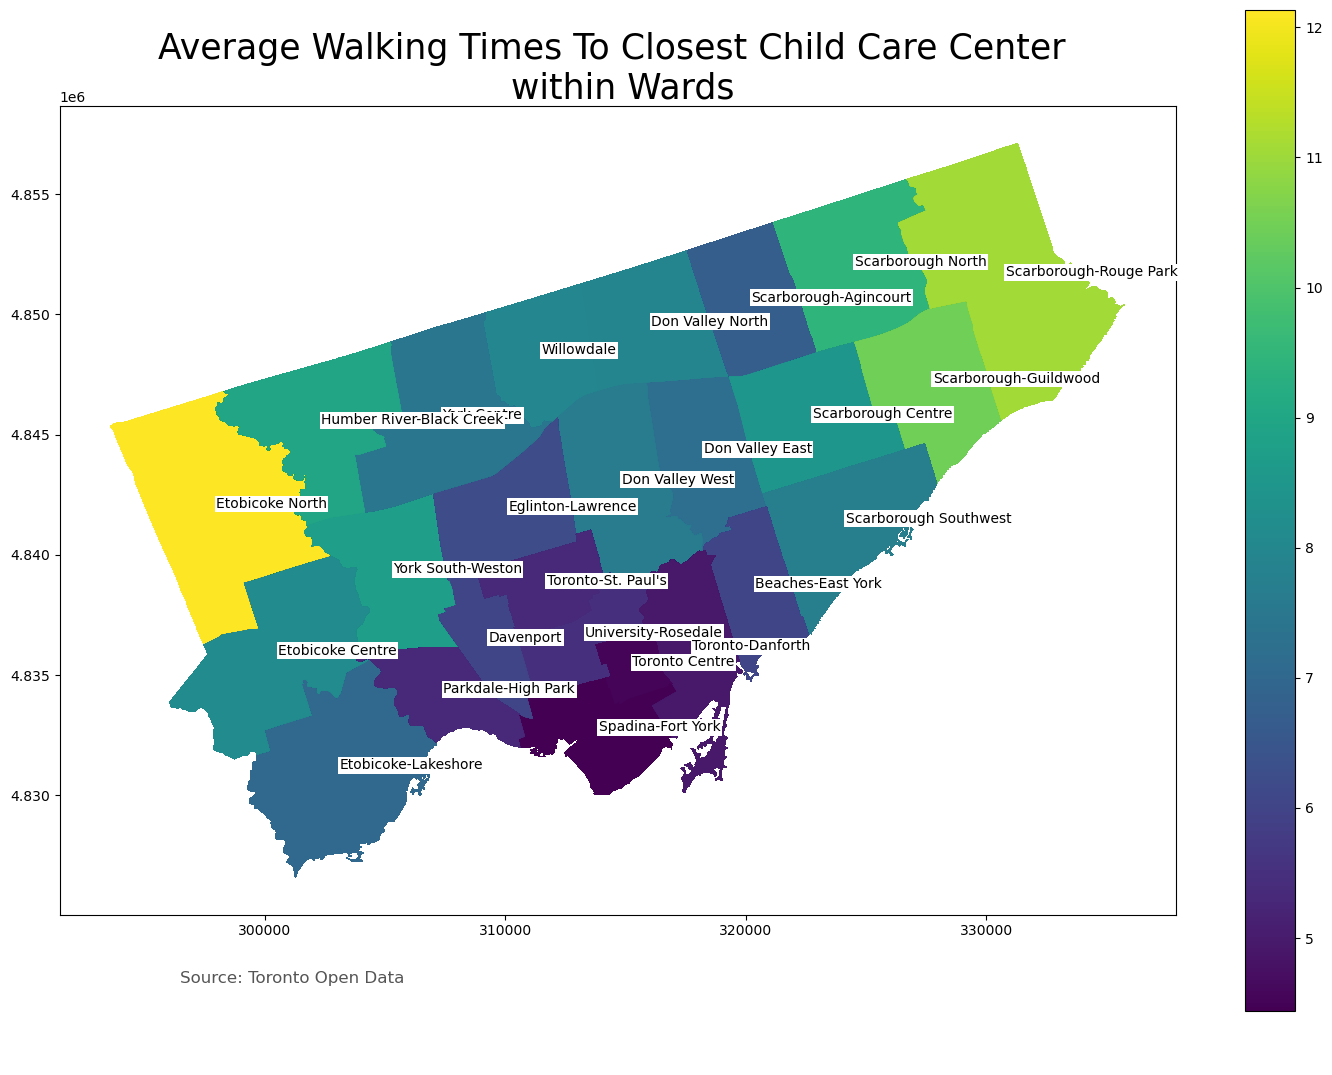

In [108]:
# plot Average Walking Times To Closest Child Care Center in Ward
ax = ward_address.plot(figsize=(18, 13), column='ward_addr_avg_min', legend=True)
ax.set_title('Average Walking Times To Closest Child Care Center \n within Wards', 
             fontdict={'fontsize': '25', 'fontweight' : '3'})

# Plot labels and add a white box behind the label using the matplotlib bbox class.
for x, y, label in zip(wards_points.geometry.x, wards_points.geometry.y, wards_points["area_name"]):
    texts.append(plt.text(x, y, label, fontsize = 10, bbox=dict(boxstyle='square,pad=0.1', fc='white', ec='none')))
# create an annotation for the data source
ax.annotate('Source: Toronto Open Data',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', 
            verticalalignment='top', fontsize=12, color='#555555')

plt.show()

### Get bounds of each Ward polygon

In [109]:
# index_left and area_name
wards.area_name

0              Don Valley East
1          Etobicoke-Lakeshore
2              Don Valley West
3            Scarborough North
4          University-Rosedale
5            Spadina-Fort York
6                    Davenport
7            York South-Weston
8             Don Valley North
9            Eglinton-Lawrence
10            Etobicoke Centre
11             Etobicoke North
12          Parkdale-High Park
13          Toronto-St. Paul's
14       Scarborough-Agincourt
15          Scarborough Centre
16       Scarborough-Guildwood
17      Scarborough-Rouge Park
18       Scarborough Southwest
19           Beaches-East York
20                  Willowdale
21                 York Centre
22    Humber River-Black Creek
23            Toronto-Danforth
24              Toronto Centre
Name: area_name, dtype: object

In [110]:
# Get bounding box coordinates and area name for a particular Ward
# Pick index number from the list above and place it in the []
minx,miny,maxx,maxy = wards.bounds.iloc[9].values
# Pick the same index number from the list above and place it in the [] to get the area name 
ward_area_name = wards.area_name.iloc[9]
ward_area_name

'Eglinton-Lawrence'

### Plotting Neighbourhood Improvement Area using bounding box co-ordinates

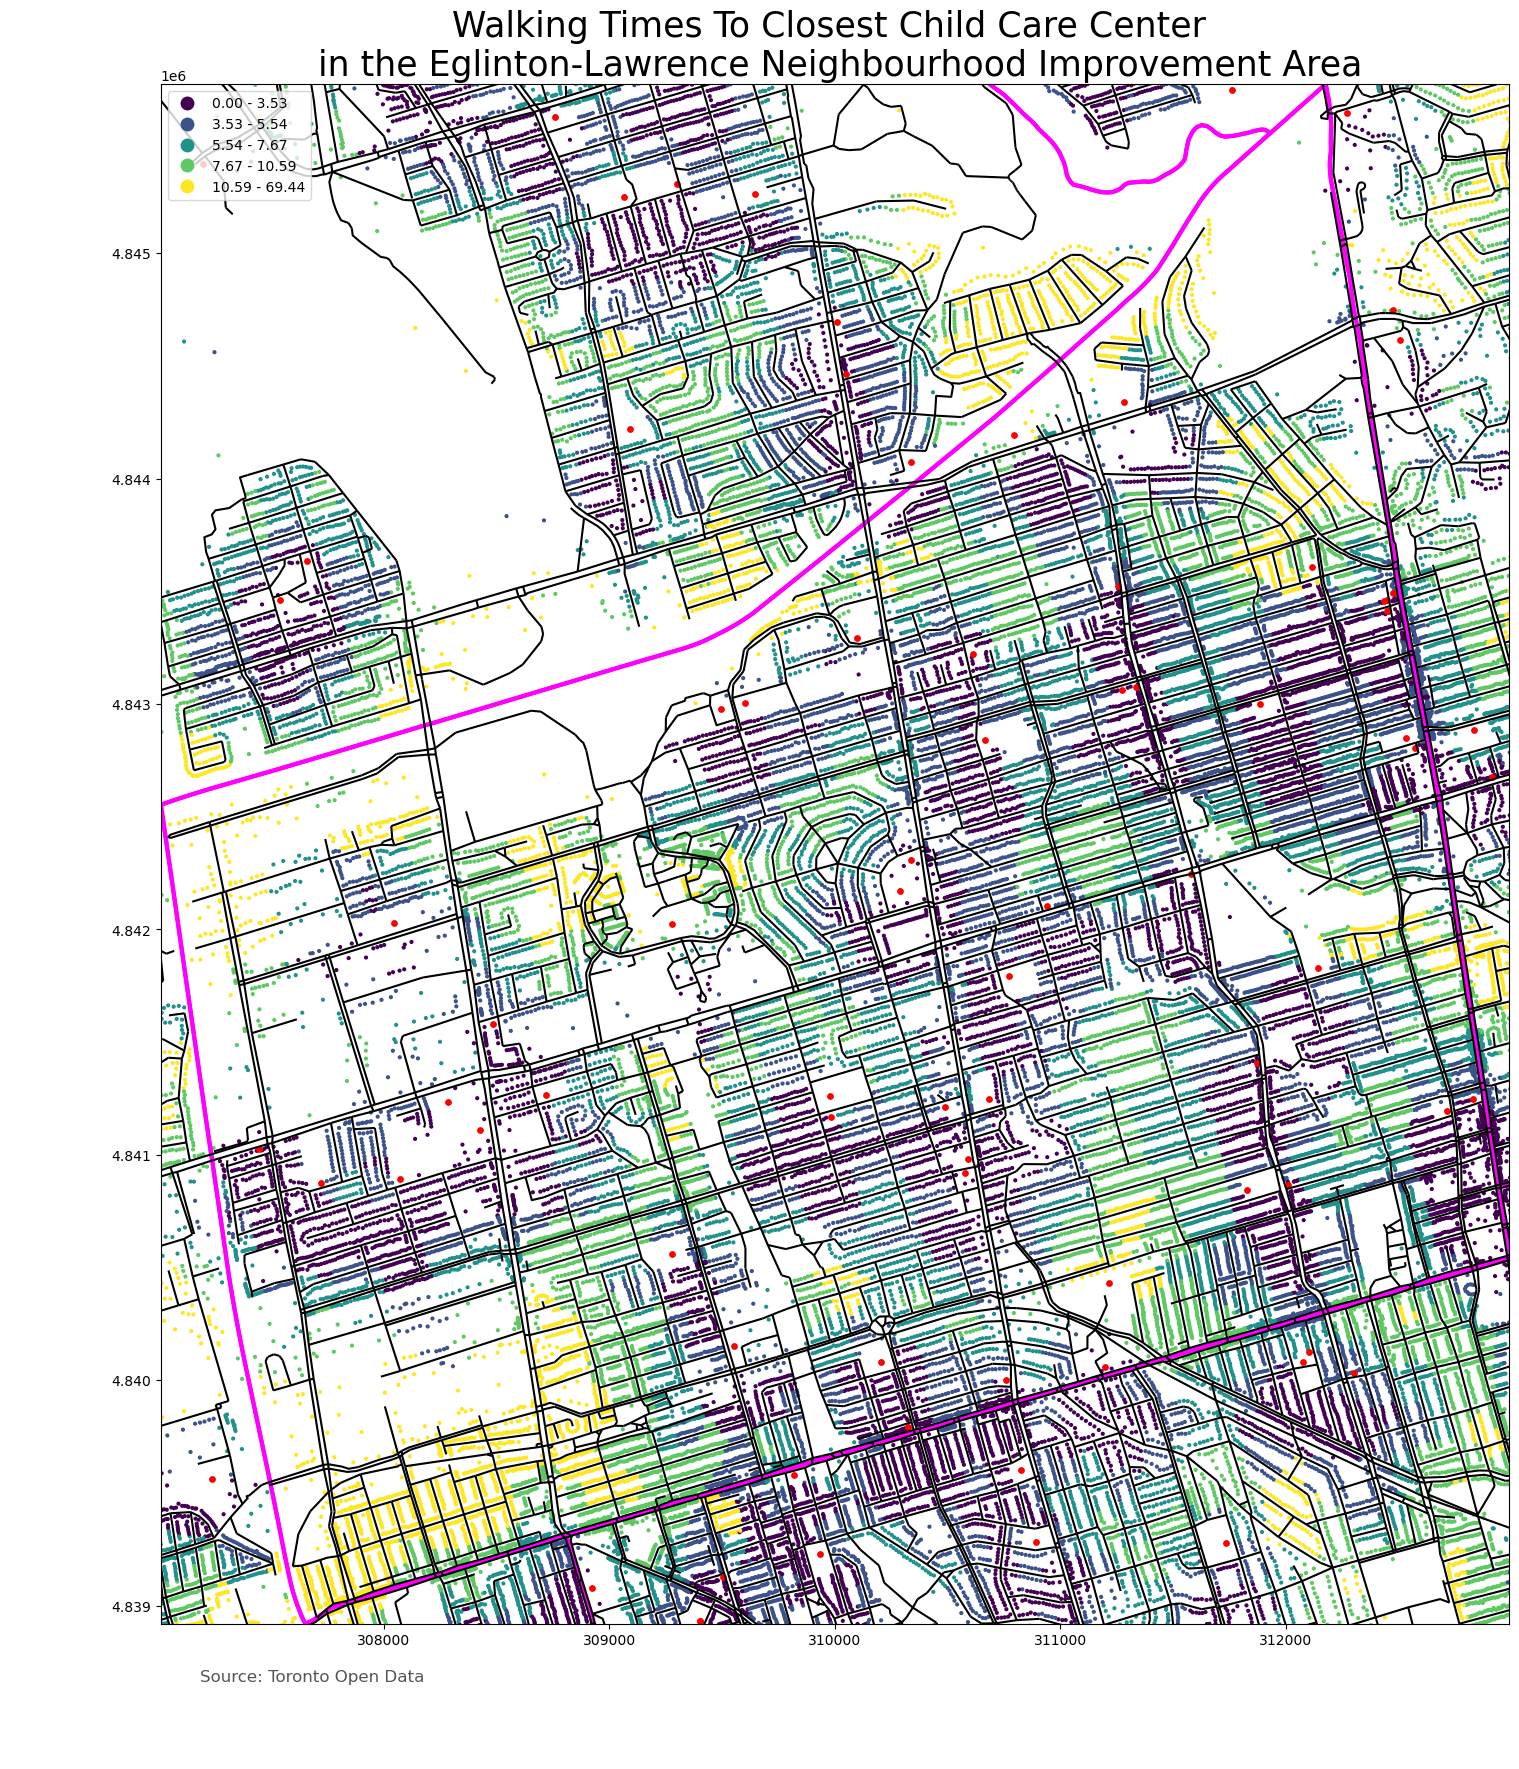

<Figure size 640x480 with 0 Axes>

In [111]:
# plotting Ward area using bounding box co-ordinates
ax = address.plot(figsize=(20, 20), column='m_child_care_0', scheme='quantiles', legend=True,markersize = 4)
wards.plot(ax=ax, facecolor='none', edgecolor='magenta', linewidth=3)
child_care.plot(ax=ax, color='red', markersize =15)
pednet.plot(ax=ax,color='black', markersize =1)

# getting limits
ax.set(xlim=(minx, maxx), ylim=(miny, maxy))

# add a title
ax.set_title((('Walking Times To Closest Child Care Center \n in the {0} Neighbourhood Improvement Area').format(ward_area_name)), 
             fontdict={'fontsize': '25', 'fontweight' : '3'})
# create an annotation for the data source
ax.annotate('Source: Toronto Open Data',xy=(0.1, .05),  xycoords='figure fraction', 
            horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')


plt.show()
plt.savefig("ccc_ward_walkability.png")